In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm

%matplotlib inline
sns.set_style("white")
plt.style.use('seaborn')
# sns.set_palette("white")

In [2]:
df_raw = pd.read_csv('../data/fl_ev_registrations_public.csv')
df_raw = df_raw[(df_raw.Technology == 'BEV')]
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249641 entries, 0 to 353791
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DMV ID                        249641 non-null  int64  
 1   DMV Snapshot (Date)           249641 non-null  object 
 2   County                        249641 non-null  object 
 3   Vehicle Name                  249641 non-null  object 
 4   Registration Valid Date       249641 non-null  object 
 5   Registration Expiration Date  0 non-null       float64
 6   Technology                    249641 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 15.2+ MB


In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2018-06-30,18115.0
2018-12-31,25458.0
2019-12-31,39789.0
2020-06-30,43123.0
2020-12-31,52877.0
2021-07-19,70279.0


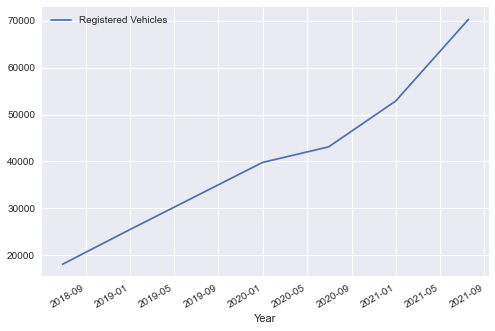

In [4]:
df = pd.DataFrame(years['Registered Vehicles']).set_axis(pd.to_datetime(years['Year'])).sort_values(by=['Year'], ascending = True).astype(float)
df.plot()
# df = df.sort_values(by=['Year'], ascending = True)
# df = df.astype(float)
df

In [5]:
# result = seasonal_decompose(df, model='multiplicative')
# fig = result.plot()


## **RESAMPLING

In [6]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [7]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

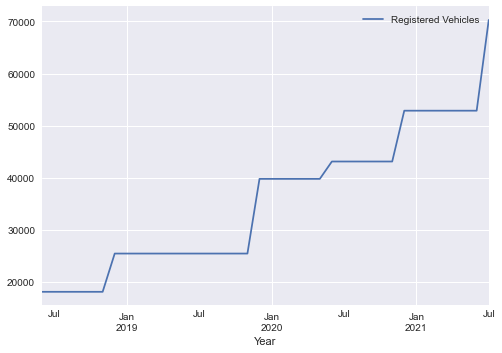

In [8]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

In [9]:
auto_model = pm.auto_arima(df, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=911.314, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=890.482, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=753.764, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=755.866, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=889.383, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=754.058, Time=0.06 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.546 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -373.882
Date:    

## Testing 

In [10]:
adtest = adfuller(df)
display(adtest)

(0.5358231579571177,
 0.9859221885122601,
 0,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 534.4673722813862)

## Modeling

In [11]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2018-06-30':'2020-12-31']
test = df['2020-12-31':]
combined = df

test

,Registered Vehicles
Year,
2020-12-31,52877.0
2021-01-31,52877.0
2021-02-28,52877.0
2021-03-31,52877.0
2021-04-30,52877.0
2021-05-31,52877.0
2021-06-30,52877.0
2021-07-31,70279.0


In [12]:
naive = train.shift(1)
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

3490.717605306966

In [13]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=734.520, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=718.797, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=604.542, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=606.576, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=718.928, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=604.595, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.533 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -299.271
Date:    

### The best model is :  ARIMA (1,00) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0346      0.020     52.230      0.000       0.996       1.073
sigma2      1.097e+07   2.66e-10   4.12e+16      0.000     1.1e+07     1.1e+07


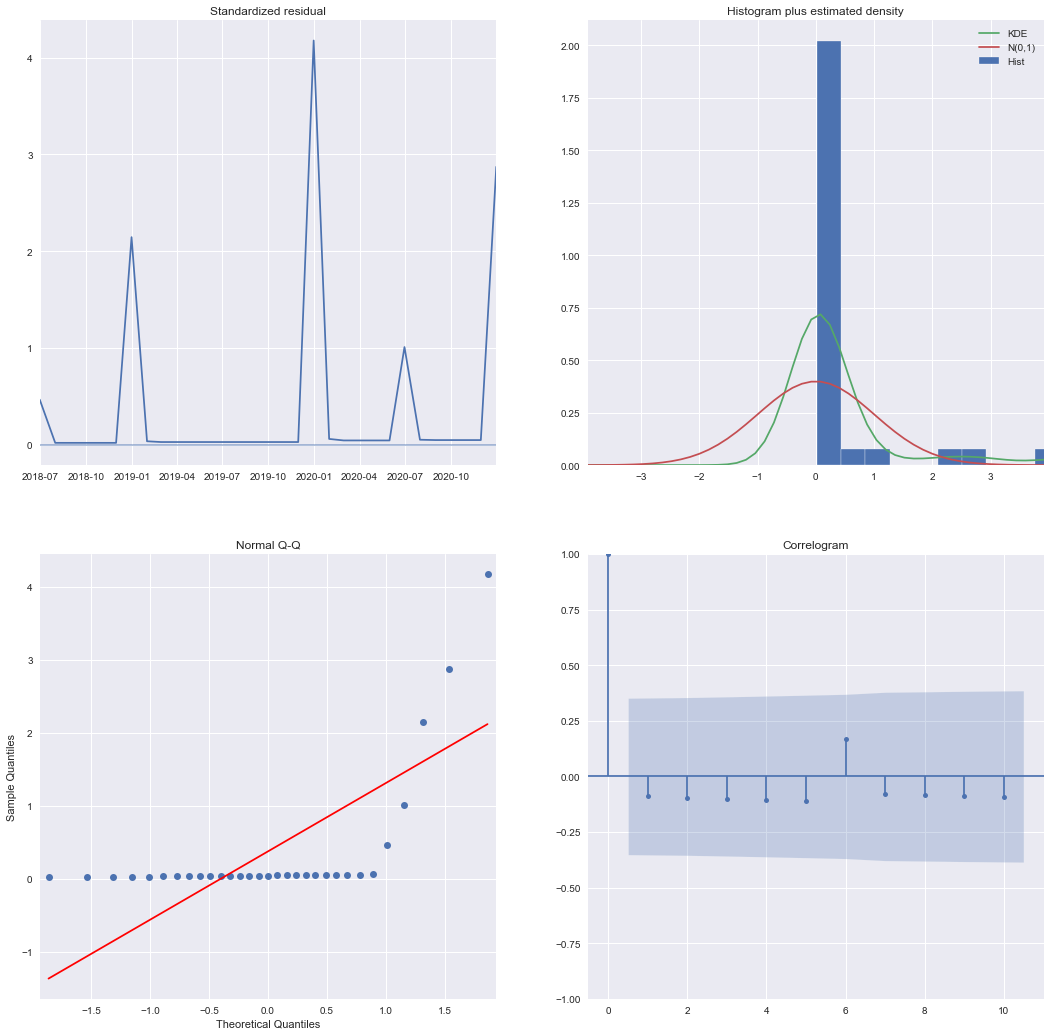

In [14]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [15]:
pred = output.get_prediction(start=pd.to_datetime('2020-12-31'), end=pd.to_datetime('2021-07-19'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2020-12-31,38121.223419,51106.616031
2021-01-31,48212.454850,61197.847462
2021-02-28,47254.371788,65938.644571
2021-03-31,46909.811464,70196.701191
2021-04-30,46893.313064,74261.999759
2021-05-31,47096.784630,78247.310180
2021-06-30,47466.219671,82211.478631
2021-07-31,47970.532392,86190.597913


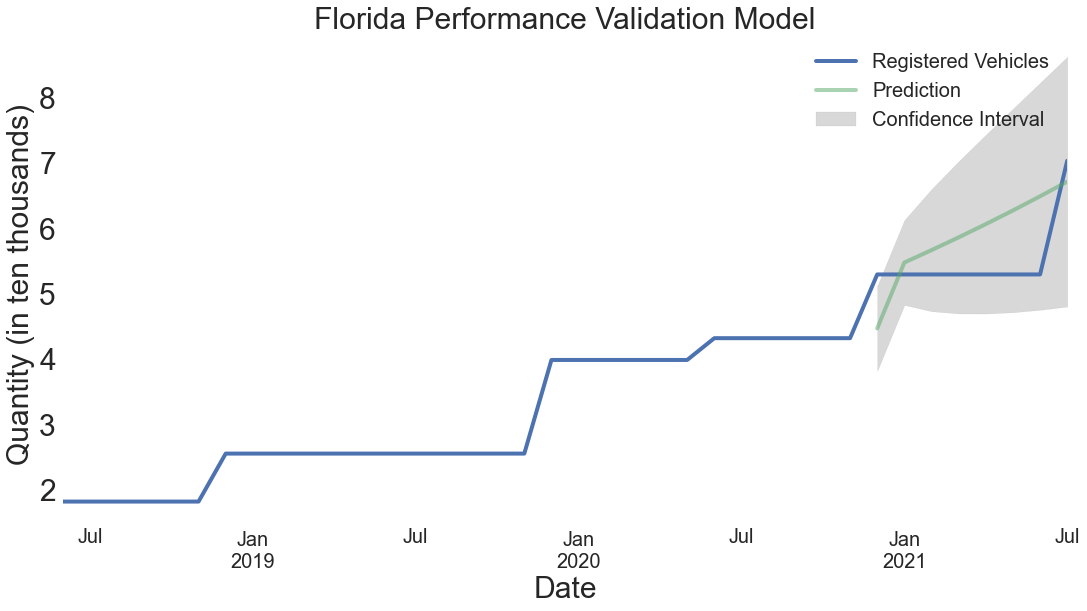

In [28]:

sns.set_style(style='white')
rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=20)
ax.set_ylabel('Quantity (in ten thousands) ',fontsize=30)
ax.tick_params(axis='x', which='minor', labelsize=20)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Florida Performance Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [17]:
# Beginning our forecasting for next 3 years (36 months)
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0346      0.020     52.230      0.000       0.996       1.073
sigma2      1.097e+07   2.66e-10   4.12e+16      0.000     1.1e+07     1.1e+07


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
forecast = full_output.get_forecast(48)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2021-08-31,65220.496118,80881.960131,73051.228124
2021-09-30,64637.951002,87227.668328,75932.809665
2021-10-31,64815.749224,93040.367139,78928.058182
2021-11-30,65413.184935,98669.729837,82041.457386
2021-12-31,66302.324533,104253.011176,85277.667854
2022-01-31,67420.072162,109862.995847,88641.534005
2022-02-28,68730.814085,115545.368611,92138.091348
2022-03-31,70212.868652,121332.279401,95772.574026
2022-04-30,71852.489387,127248.355907,99550.422647
2022-05-31,73640.843968,133313.740891,103477.292430


August of 2024: 

301180 EV's on the road

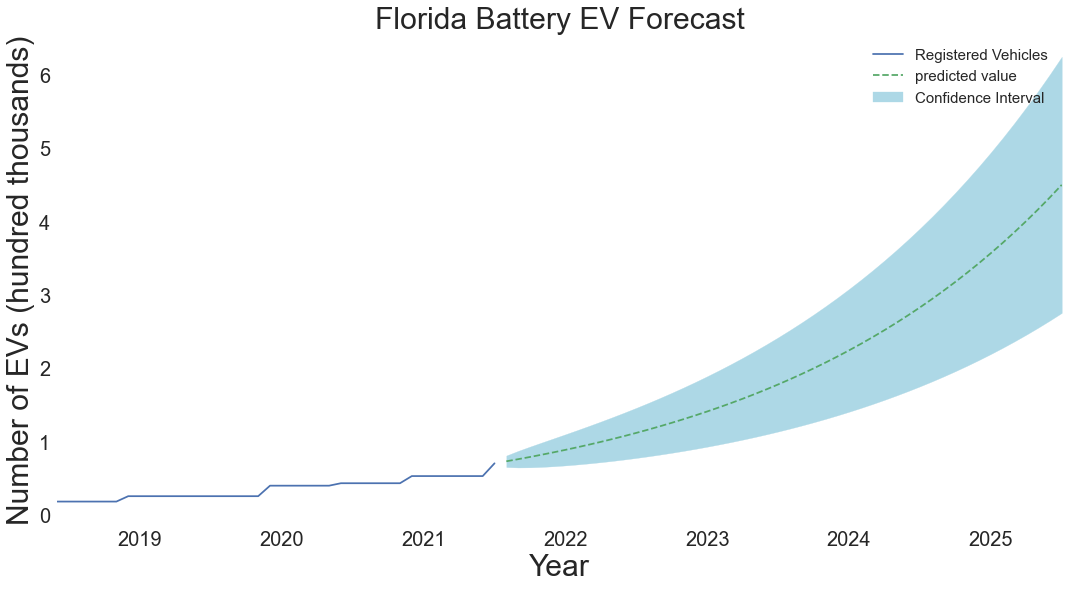

In [22]:
sns.set_style(style='white')
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Actual')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'], color = 'lightblue',
                label='Confidence Interval')


ax.set_xlabel('Year',fontsize=30)
plt.xticks(fontsize=20)
ax.set_ylabel('Number of EVs (hundred thousands)',fontsize=30)
plt.yticks(fontsize=20)

scale_y = 1e5
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Florida Battery EV Forecast',fontsize=30)
plt.legend(fontsize = 15)
plt.show()